In [2]:
import cv2

import numpy as np
import matplotlib.pyplot as plt

# Lendo o vídeo

In [3]:
cap = cv2.VideoCapture('entrada.avi')
frames = []

while cap.isOpened():
    ret, frame = cap.read()
    if ret == False:
        print('*** Video ended ***')
        break
        
    frames.append(frame)
    
frames = np.array(frames)

*** Video ended ***


# Função show

- A função *show* foi definida para que pudessemos ver as imagens na célula do notebook sem precisarmos abrir a janela extra do OpenCV, facilitando os testes e análises.

In [4]:
def show(img):
    """
        Exibe uma imagem, na própria célula, usando matplotlib
        
        Parâmetros:
        ----------
        img : numpy.ndarray
            Imagem a ser exibida
    """
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(img, cmap=plt.cm.gray)
    ax.set_axis_off()
    plt.show()

# Função homography
- Função criada para estimar a matriz de homografia utilizando a função findHomography com o método RANSAC para filtrar erros grosseiros e a função warpPerspective para aplicar tal matriz na imagem.
- Irá retornar o resultado binarizado para realizarmos posteriormente um template matching mais preciso.

In [5]:
def homography(img, src, target):
    """
        Estima e aplica a matriz de homografia em um conjunto de pontos
        
        Parâmetros
        ----------
        img : numpy.ndarray
            Imagem de onde os pontos foram extraídos
            
        src : numpy.ndarray
            Pontos de origem (da imagem)
            
        target : numpy.ndarray
            Pontos do alvo
            
        Retorno
        -------
        numpy.ndarray
            Retorna aquela parte da imagem binarizada e com a homografia aplicada
    """
    
    # Obtendo os pontos no alvo e estimando a matriz de homografia usando RANSAC
    dst = np.float32([[0,0], [0, target.shape[1]], [target.shape[0], target.shape[1]], [target.shape[0], 0]])
    M = cv2.findHomography(src, dst, cv2.RANSAC)[0]
    
    # Aplicando o warpPerspective e binarizando a imagem
    result = cv2.warpPerspective(img, M, (target.shape[0], target.shape[1]))
    result[result < 80] = 0
    result[result >= 80] = 255
    
    return result

# Função get_targets
- Função auxiliar usada para ler o arquivo que contêm o alvo, retornando o mesmo rotacionado em 0º, 90º, 180º e 270º respectivamente.

In [6]:
def get_targets(filename):
    """
        Retorna o alvo rotacionado em 0º, 90º, 180º e 270º
        
        Parâmetros
        ----------
        filename : str
            Nome do arquivo, .jpg por exemplo, do alvo
            
        Retorno
        -------
        list
            Lista contendo o alvo rotacionado em 0º, 90º, 180º e 270º (nessa ordem)
    """
    
    # Lendo o alvo, convertendo para escalas de cinza e binarizando
    target = cv2.imread(filename)
    target = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)
    target[target < 25] = 0
    target[target >= 25] = 255
    
    targets_list = []
    
    # Rotacionando o alvo em cada um dos ângulos e salvando em uma lista
    for angle in [0, 90, 180, 270]:
        M = cv2.getRotationMatrix2D((target.shape[1]/2, target.shape[0]/2), angle, 1)
        targets_list.append(cv2.warpAffine(target, M, (target.shape[0], target.shape[1])))
                            
    return targets_list

# Função similarity_func

- Função criada para retornar o quão similar duas imagens são.
- Fizemos um cálculo de diferença média absoluta dos pixels para tal.

In [7]:
def similarity_func(img1, img2):
    """
        Função de similaridade usando a diferença média dos pixels
        
        Parâmetros
        ----------
        img1 : numpy.ndarray
            Imagem 1 a ser comparada
            
        img2 : numpy.ndarray
            Imagem 2 a ser comparada
            
        Retorno
        -------
            Retorna o valor da diferença média dos pixels
    """
    
    return np.sum(np.abs(img1 - img2)) / (img1.size)

# Função template_matching
- Essa função cumpre o papel de: para cada imagem do alvo rotacionado, verificar o quão similar ela é com a imagem obtida no passo da homografia. Salvando o índice da imagem que possui o menor valor retornado pela função similarity_func, em outras palavras, a mais similar.
- Caso essa imagem não possua valor de similaridade menor do que a tolerância definida, não aceitamos e retornamos -1. Caso contrário, retornamos o índice encontrado.

In [8]:
def template_matching(img, targets, sim_func, tol=25):
    """
        Função que realiza o casamento de template
        
        Parâmetros
        ----------
        img : numpy.ndarray
            Imagem que se quer casar
            
        targets : numpy.ndarray list
            Lista de alvos que iremos casar
            
        simFunc : function
            Função de similaridade que aceita dois numpy.ndarray,
            realiza os cálculos e retorna um número
            
        tol : float, opcional
            Tolerância para ser um casamento válido (por padrão é 20)
            
        Retorno
        -------
        int
            Caso o valor de similaridade esteja abaixo da tolerância,
            retornamos o índice do alvo que resultou em um casamento
            bem-sucedido (seguindo a mesma ordem dos ângulos).
            Senão, retornamos -1.
    """
    
    min_similarity = sim_func(img, targets[0])
    min_pos = 0
    
    # Caminhando por cada alvo, comparando o valor de similaridade do atual e 
    # atualizando, caso necessário, as variáveis
    for i in range(1, len(targets)):
        current = sim_func(img, targets[i])
        if current < min_similarity:
            min_similarity = current
            min_pos = i
    
    return min_pos if min_similarity <= tol else -1

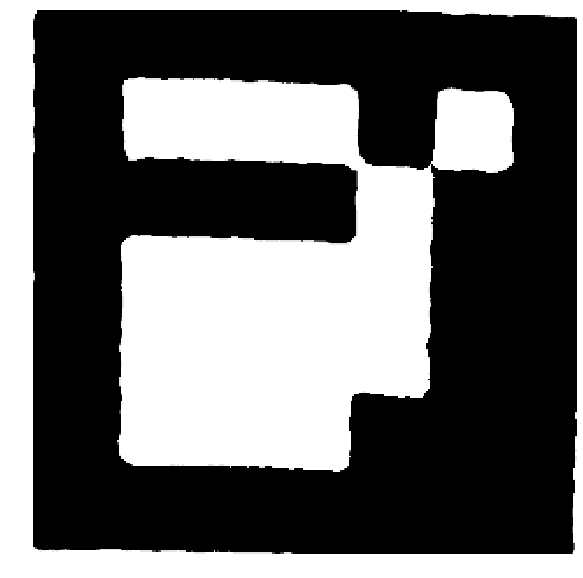

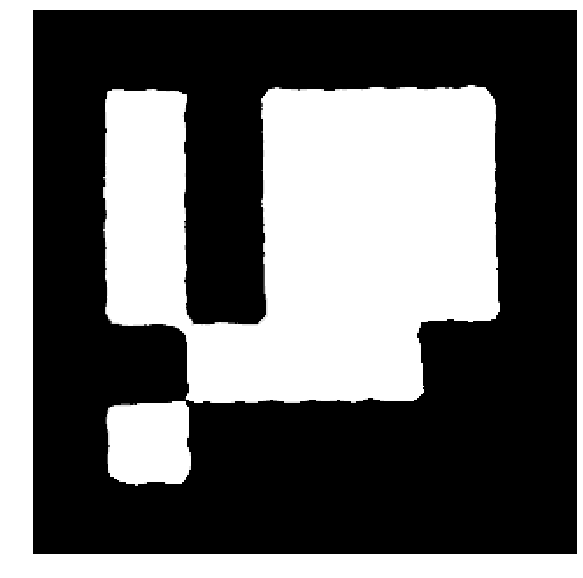

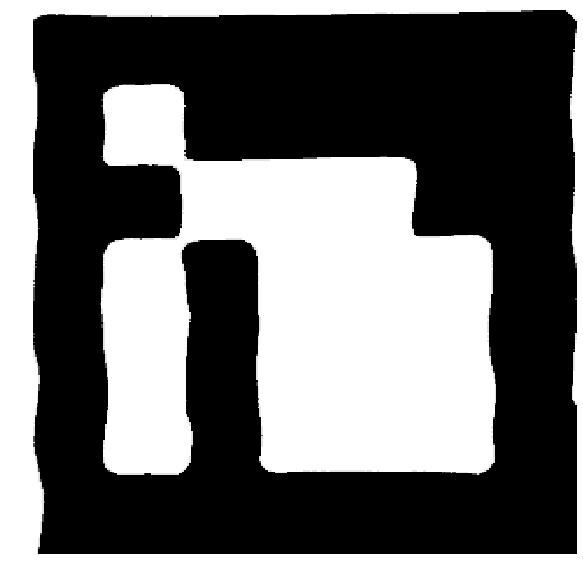

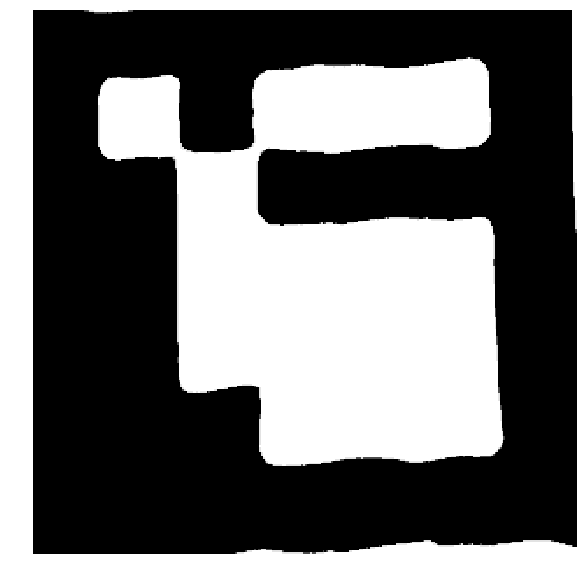

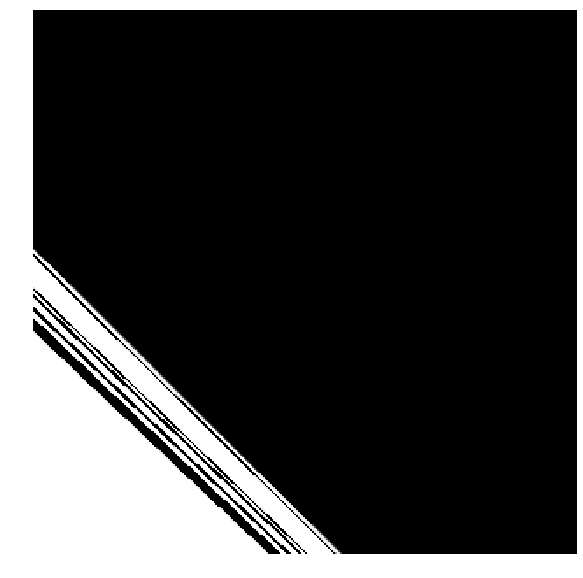

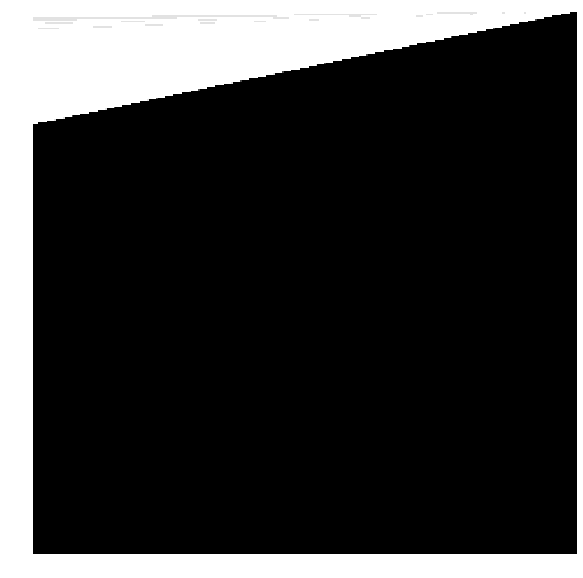

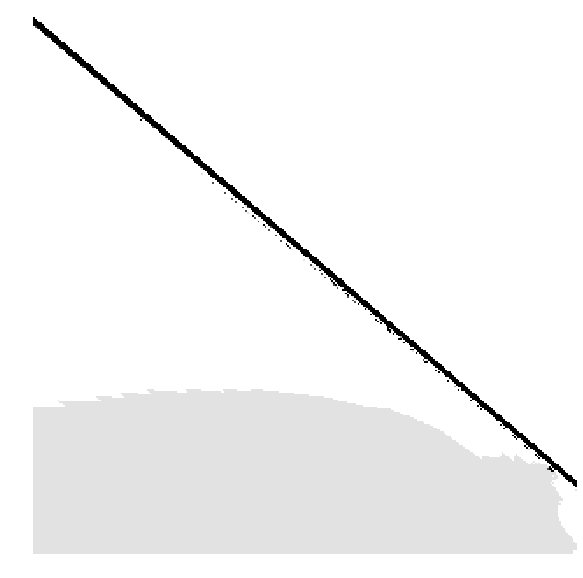

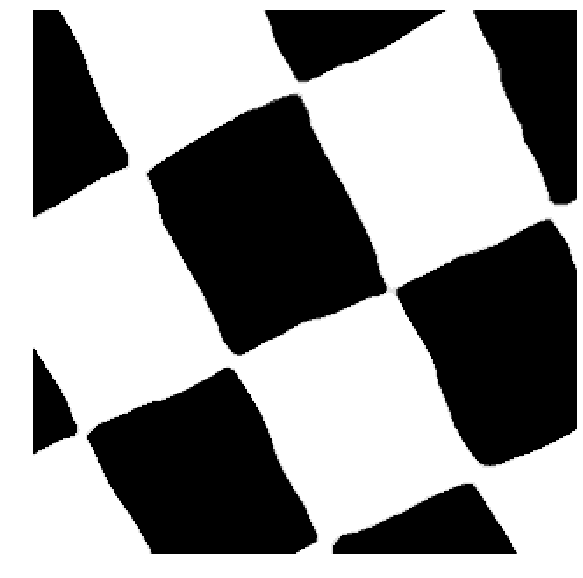

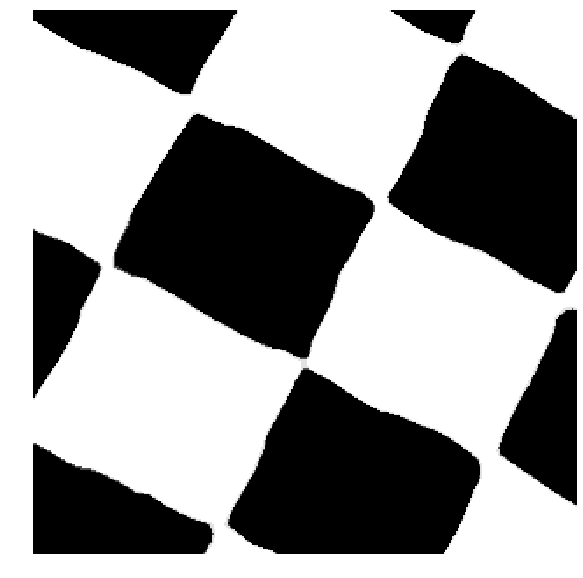

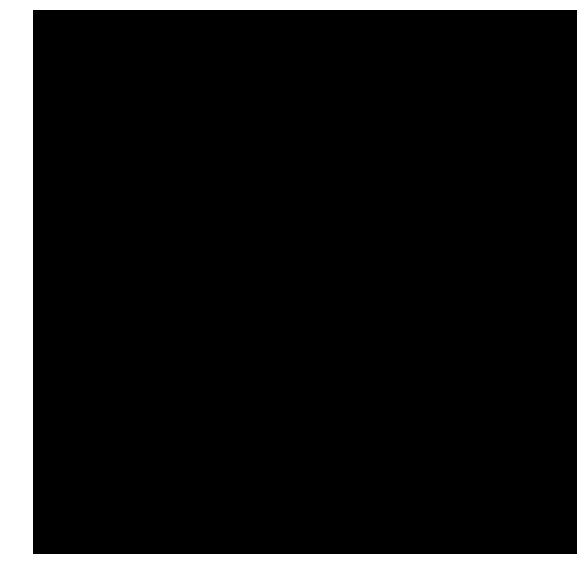

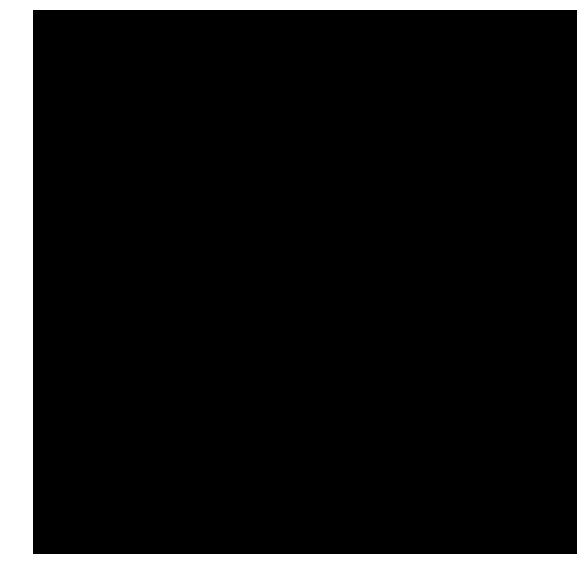

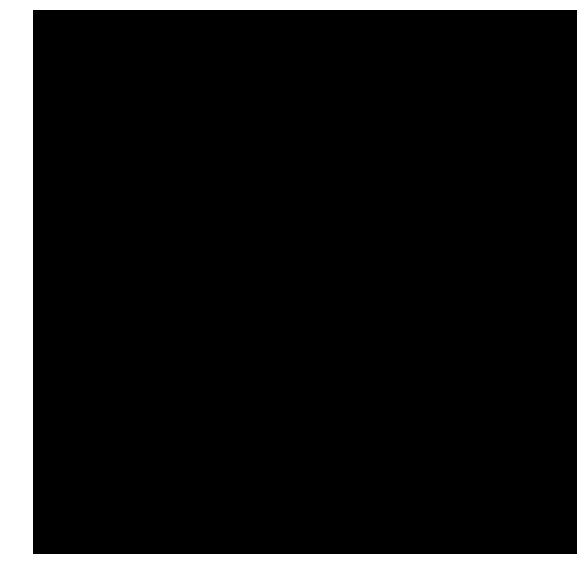

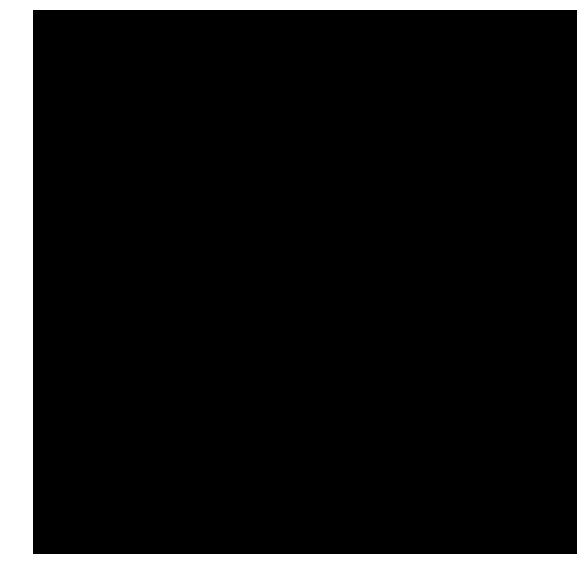

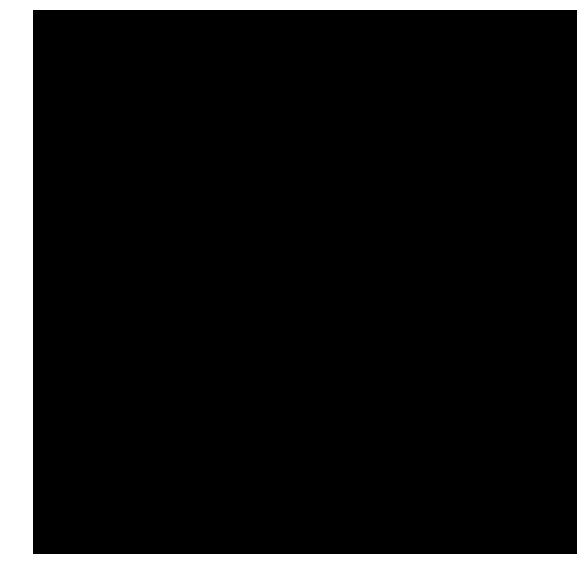

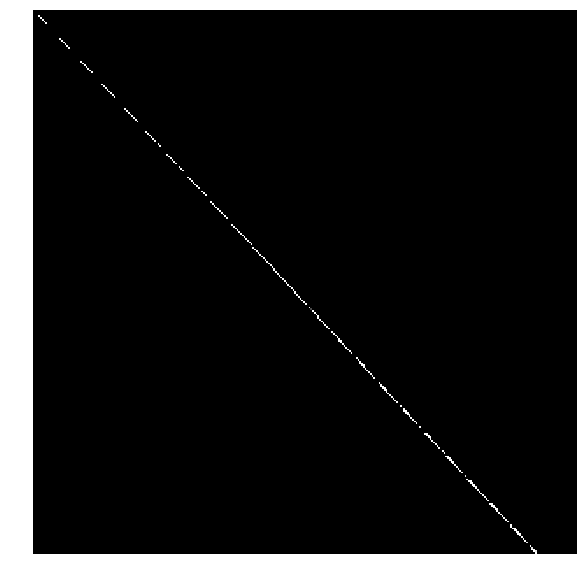

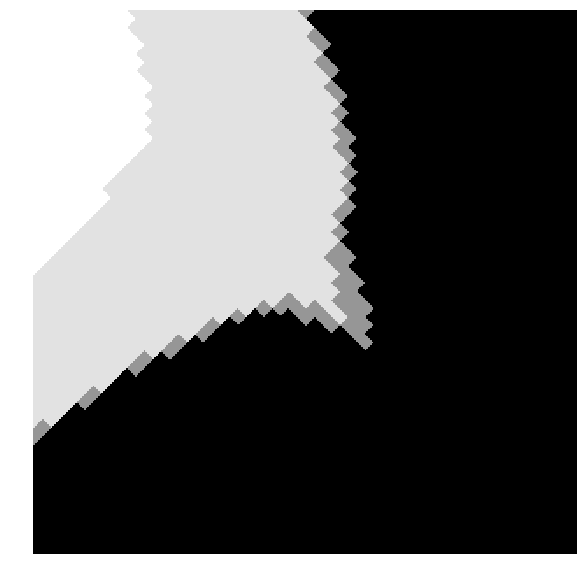

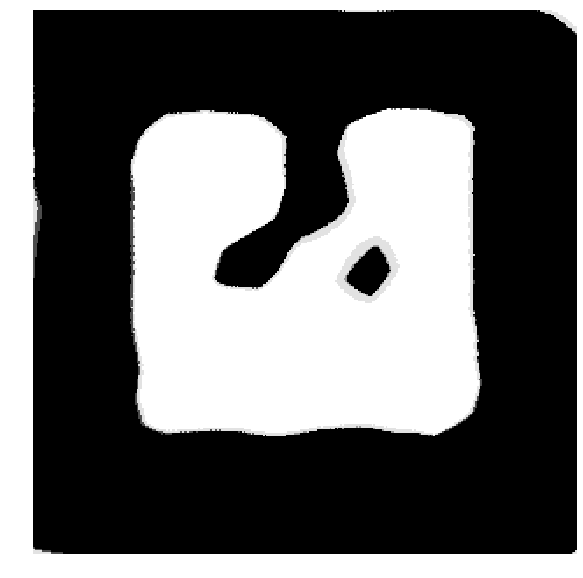

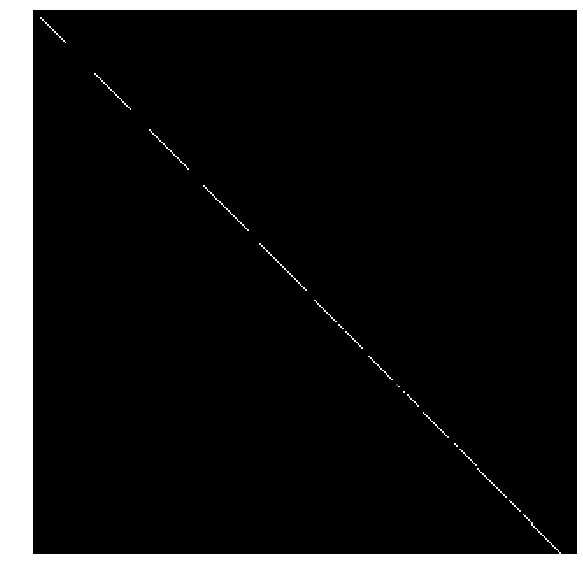

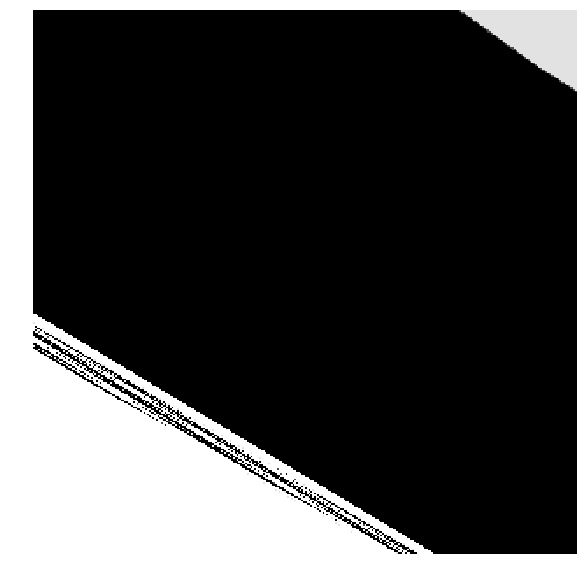

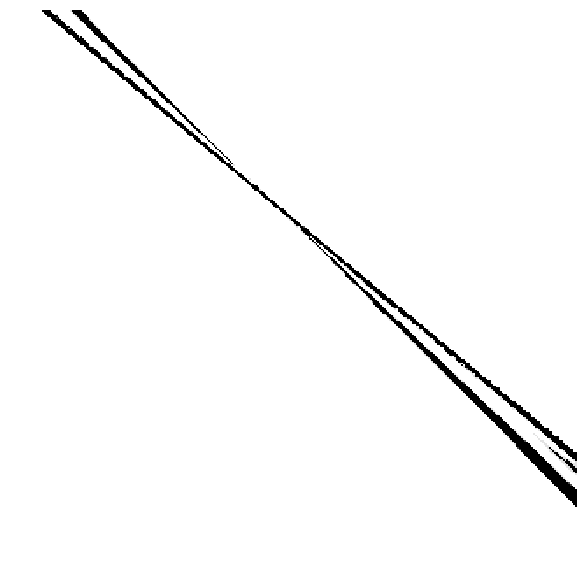

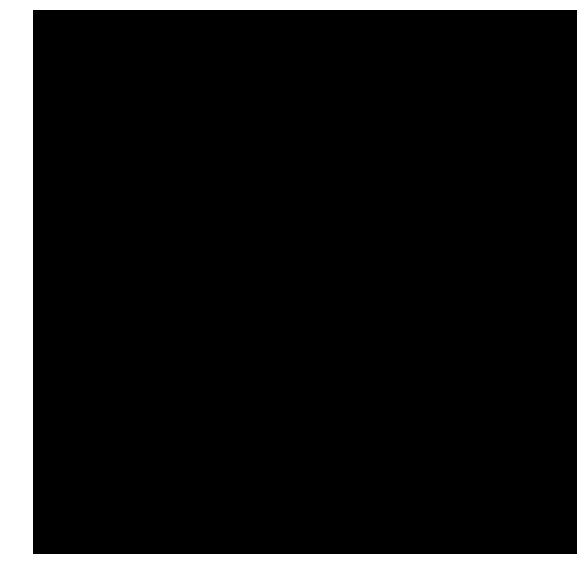

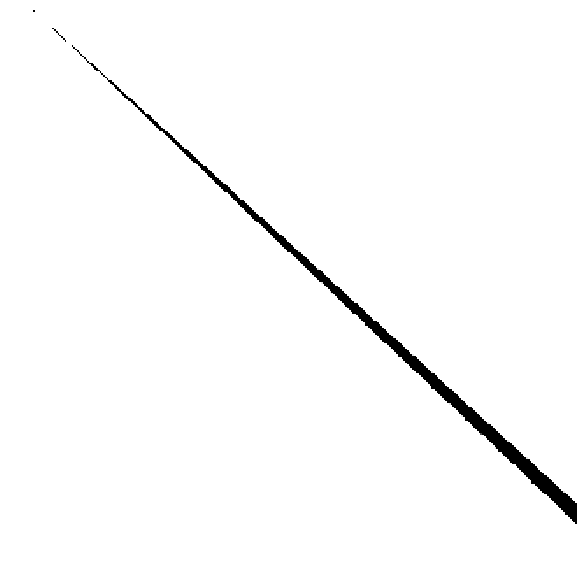

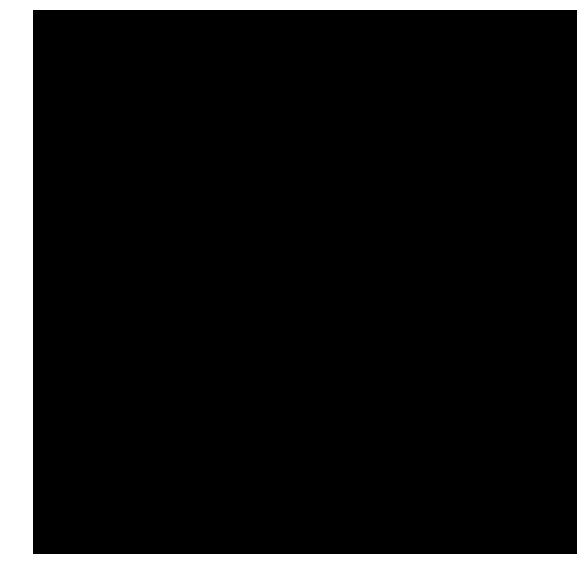

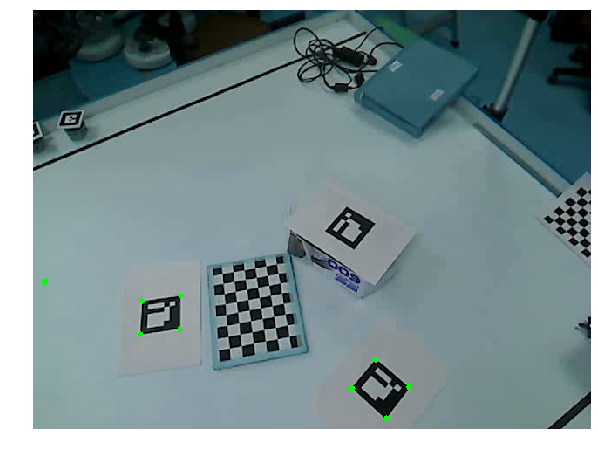

In [12]:
targets = get_targets('alvo.jpg')
frame = frames[0].copy()
# Convertendo a imagem para tons de cinza
gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

# Detectando bordas com Canny e contornos
canny = cv2.Canny(gray, 150, 200)
contours, _ = cv2.findContours(canny, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Guardando uma lista de pontos para os possíveis alvos
pts = []
pos = []

for c in contours:
    # Aproximando o contorno via um polígono 
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.015 * peri, True)

    # Caso esse polígono possua 4 pontos adicionamos ele na nossa lista se a homografia retornar como correto
    if len(approx) == 4:
        homog = homography(frame, approx, targets[0])
        homog = cv2.cvtColor(homog, cv2.COLOR_BGR2GRAY)
        show(homog)
        pos_target = template_matching(homog, targets, similarity_func)
        if  pos_target != -1:
            pos.append(pos_target)
            pts.append(approx)

# Desenhando os contornos
for c in pts:
    cv2.drawContours(frame, c, -1, (0,255,0), 5)

show(frame)
        
#     # Exibindo o frame
#     cv2.imshow('Teste', frame)
    
#     # Caso o usuário aperte 'q', o vídeo termina
#     if cv2.waitKey(15) == ord('q'):
#         break
        
# cv2.destroyAllWindows()

In [9]:
for frame in frames.copy():
    # Convertendo a imagem para tons de cinza
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    
    # Detectando bordas com Canny e contornos
    canny = cv2.Canny(gray, 150, 200)
    contours, _ = cv2.findContours(canny, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Guardando uma lista de pontos para os possíveis alvos
    pts = []
    
    for c in contours:
        # Aproximando o contorno via um polígono 
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        
        # Caso esse polígono possua 4 pontos adicionamos ele na nossa lista (um provável alvo)
        if len(approx) == 4:
            pts.append(approx)

    # Desenhando os contornos
    for c in pts:
        cv2.drawContours(frame, c, -1, (0,255,0), 5)
        
    # Exibindo o frame
    cv2.imshow('Teste', frame)
    
    # Caso o usuário aperte 'q', o vídeo termina
    if cv2.waitKey(15) == ord('q'):
        break
        
cv2.destroyAllWindows()